In [1]:
import sys

sys.path.insert(0, '../')

from modules.spec_dataset import *
from modules.VT_dataset import *

In [41]:
# Define transformations to apply to the dataset images. In this case, converting images to tensors.
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),  # Transform images to PyTorch tensors
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),  # Transform images to PyTorch tensors
    ]),
}

# Setup datasets for training and validation using specified directories and behavior files,
# applying the previously defined transformations to each dataset.
spec_dsets = {
    'train': RawDataset(train_dir, train_behav_file, data_transforms['train']),  # Training dataset
    'val': RawDataset(val_dir, val_behav_file, data_transforms['val'])  # Validation dataset
}

# Calculate dataset sizes for train and validation sets to manage samples during training.
spec_dset_sizes = {split: len(spec_dsets[split]) for split in ['train', 'val']}  # Dictionary comprehension to calculate sizes

# Initialize dictionary to store data loaders for both training and validation datasets.
spec_dset_loaders = {}

# Loop over each dataset split (train, val) to set up data loaders.
for split in ['train', 'val']:
    # Get array of labels for the current dataset split.
    targets = np.array([spec_dsets[split].get_label(i) for i in range(len(spec_dsets[split]))])

    # Get counts of each class in the current dataset split.
    class_counts = spec_dsets[split].get_class_counts()

    # Calculate class weights as the inverse of class counts, handling classes with zero instances.
    class_weights = np.array([1.0 / class_counts[label] if class_counts[label] > 0 else 0 for label in targets])

    # Setup a weighted random sampler to handle class imbalance by assigning weights to each sample.
    sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)

    # Create data loaders for each split using the sampler for handling class imbalance,
    # defining batch size and number of worker processes.
    spec_dset_loaders[split] = torch.utils.data.DataLoader(
        spec_dsets[split],  # Dataset
        batch_size=b_size,  # Batch size defined elsewhere
        num_workers=0,  # Number of subprocesses to use for data loading (0 means that the data will be loaded in the main process)
        sampler=sampler  # Use the weighted random sampler
    )

    # Print completion status of loader setup for each split.
    print('done making loader:', split)


100%|██████████| 192/192 [00:09<00:00, 20.97it/s]


Class counts:  {'HEHF': 2489, 'HELF': 238, 'LEHF': 1371, 'LELF': 878}


100%|██████████| 48/48 [00:02<00:00, 20.09it/s]

Class counts:  {'HEHF': 508, 'HELF': 101, 'LEHF': 535, 'LELF': 100}
done making loader: train
done making loader: val


In [13]:
# Getting a random subject and song for our sample data
rand_subj = torch.randint(low=1, high=num_sub, size=(1,)).item()
rand_song = torch.randint(low=1, high=num_sess, size=(1,)).item()

rand_data_path = f'pre_eeg_sub-0{rand_subj//10}{rand_subj%10}_ses-{rand_song//10}{rand_song%10}_eeg.fif'

if rand_subj <= 16:
    rand_data_path = os.path.join(train_dir, rand_data_path)
else:
    rand_data_path = os.path.join(val_dir, rand_data_path)

# Reading the data from the .fif file
raw = mne.io.read_raw_fif(rand_data_path, preload=True)

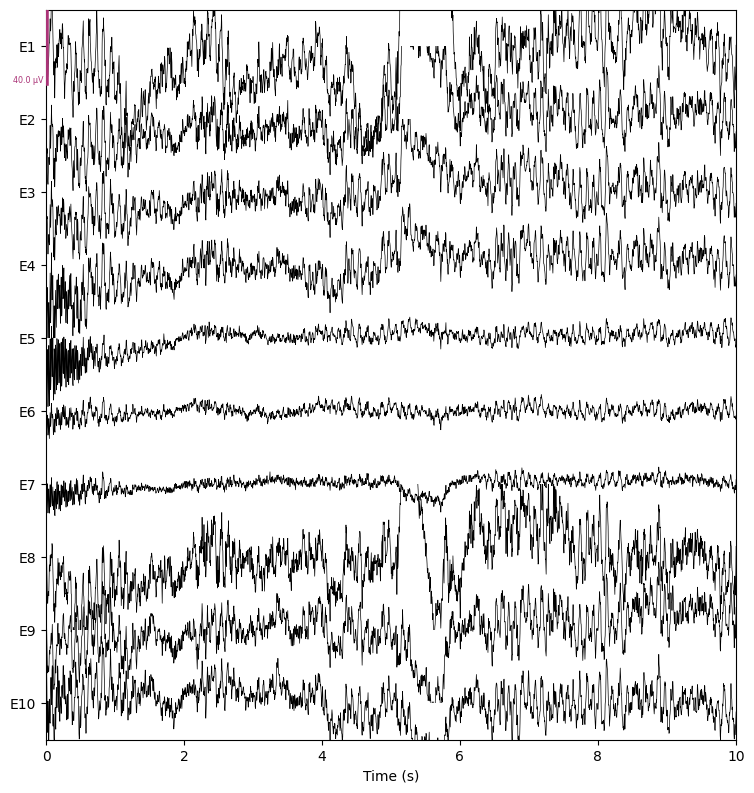

Voltage vs. Time for Subject 5 Listening to Song 11
tensor([[-5.0837e-06, -1.1377e-05, -1.3996e-05,  ..., -3.5518e-05,
         -4.0897e-05, -4.8123e-05],
        [-5.1243e-06, -1.6119e-05, -1.9251e-05,  ...,  4.2998e-06,
          7.0308e-06, -2.9833e-06],
        [-3.9683e-06, -1.4038e-05, -1.7057e-05,  ...,  1.4882e-05,
          1.5177e-05,  6.5481e-06],
        ...,
        [ 7.0648e-07,  2.6393e-06,  5.1118e-06,  ...,  3.0872e-06,
         -2.1059e-06, -1.1028e-05],
        [ 5.8822e-08,  4.1294e-06,  6.1791e-06,  ...,  1.4211e-05,
          1.0892e-05,  1.4385e-06],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
shape of the data is: torch.Size([129, 1250])


In [44]:
raw.set_annotations(None)

# Plot the data with specified parameters, including the empty events array
mne.viz.plot_raw(
    raw,
    n_channels=10,               # Number of channels to display at once
    show_options=False,          # Disable the interactive options menu
    clipping="transparent",      # Allow signal exceeding bounds to be invisible rather than clipped
    proj=False,                  # Disable SSP projections being applied automatically in the plot
    show_scrollbars=False,       # Hide the horizontal scrollbar
)

print(f'Voltage vs. Time for Subject {rand_subj} Listening to Song {rand_song}')
# Across all channels from 0 to 5 seconds
print(torch.Tensor(raw.get_data()[:, 0:1250]))
print(f'shape of the data is: {torch.Tensor(raw.get_data()[:, 0:1250]).shape}')


In [15]:
# Define frequencies of interest (log-spaced)
frequencies = np.logspace(np.log10(1), np.log10(40), num=20)
n_cycles = frequencies / 8.  # Different number of cycle per frequency
# Compute time-frequency representation with Morlet wavelets
power = tfr_morlet(raw, freqs=frequencies, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=6, n_jobs=-1)

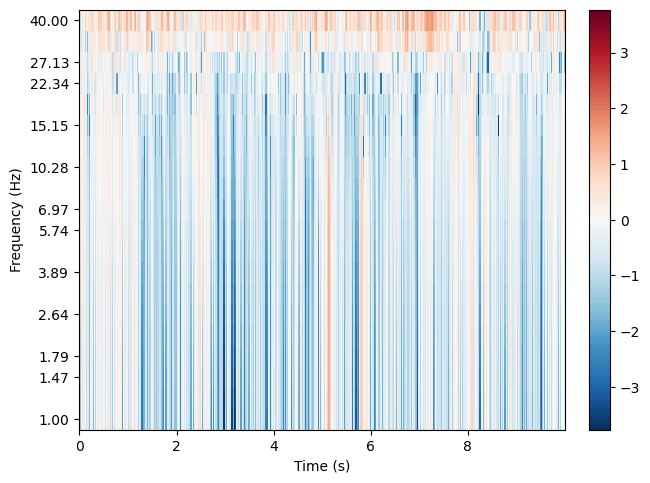

Channel 1 Spectrogram for Subject 5 Listening to Song 11
tensor([[1.7111e-09, 3.9787e-09, 6.1872e-09,  ..., 1.6664e-10, 1.3207e-11,
         2.5938e-11],
        [5.4940e-09, 1.9735e-09, 2.7982e-09,  ..., 3.3797e-11, 1.8782e-12,
         9.3370e-12],
        [5.2320e-09, 1.5043e-09, 2.2676e-09,  ..., 2.5953e-11, 4.2230e-12,
         3.5098e-12],
        ...,
        [8.7624e-10, 2.5714e-09, 6.1543e-09,  ..., 1.5537e-10, 1.9892e-11,
         2.1876e-11],
        [3.9470e-10, 1.7852e-09, 5.3937e-09,  ..., 1.0087e-10, 7.0156e-12,
         1.2739e-11],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
shape of the data is: torch.Size([129, 840])


In [45]:
# Choosing the channel to plot
first_channel_idx = 0
# Plots the spectrogram of the data for our selected channel
power.plot(picks=first_channel_idx, baseline=(-0.5, 0), mode='logratio', show=True, colorbar=True, tmin=0, tmax=10)
print(f'Channel {first_channel_idx+1} Spectrogram for Subject {rand_subj} Listening to Song {rand_song}')

# Across all channels from 0 to 1 seconds
eeg_data = power.get_data()[:, :, 0 : 84]

eeg_data = torch.Tensor(eeg_data)

# eeg_data has shape (129, 20, 84), we need to reduce the time bins to 42
# Reshape eeg_data to merge each pair of time bins
eeg_data = eeg_data.reshape(eeg_data.shape[0], eeg_data.shape[1], eeg_data.shape[2] // 2, 2)

# Compute the mean across the last dimension to average adjacent bins
eeg_data = eeg_data.mean(dim=3)

# Reshaping the data by flattening the last 2 dims
new_shape = (eeg_data.shape[0], eeg_data.shape[1] * eeg_data.shape[2])  # (129, 20*42)
eeg_data = eeg_data.reshape(new_shape)

print(eeg_data)
print(f'shape of the data is: {eeg_data.shape}')
# eeg_data has shape (129, 840)

In [31]:
# Getting our raw data (before preprocessing)
raw_data_path = f'../../ds003774/sub-0{rand_subj//10}{rand_subj%10}/ses-{rand_song//10}{rand_song%10}/eeg/sub-0{rand_subj//10}{rand_subj%10}_ses-{rand_song//10}{rand_song%10}_task-MusicListening_run-{rand_song}_eeg.set'
very_raw = read_raw_eeglab(raw_data_path, preload=True)

/var/folders/53/gd2sphbj5y18dj98twnzbqjm0000gn/T/ipykernel_32496/1747812791.py:2: RuntimeWarning: Omitted 110 annotation(s) that were outside data range.
  very_raw = read_raw_eeglab(raw_data_path, preload=True)
/var/folders/53/gd2sphbj5y18dj98twnzbqjm0000gn/T/ipykernel_32496/1747812791.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  very_raw = read_raw_eeglab(raw_data_path, preload=True)


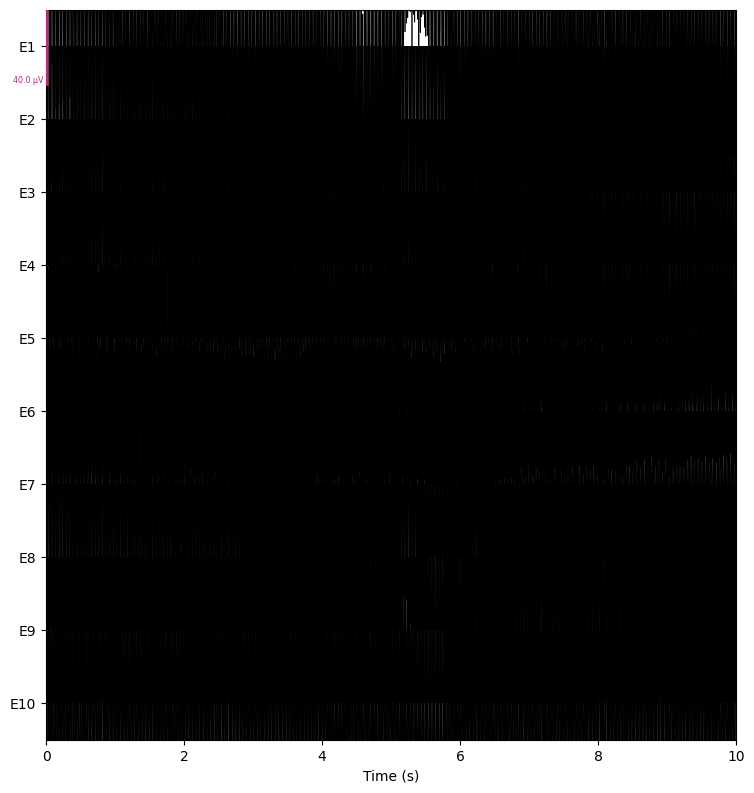

Voltage vs. Time for Subject 5 Listening to Song 11


In [32]:
very_raw.set_annotations(None)

# Plot the data with specified parameters, including the empty events array
mne.viz.plot_raw(
    very_raw,
    n_channels=10,               # Number of channels to display at once
    show_options=False,          # Disable the interactive options menu
    clipping="transparent",      # Allow signal exceeding bounds to be invisible rather than clipped
    proj=False,                  # Disable SSP projections being applied automatically in the plot
    show_scrollbars=False,       # Hide the horizontal scrollbar
)

print(f'Voltage vs. Time for Subject {rand_subj} Listening to Song {rand_song}')

In [33]:
# Compute time-frequency representation with Morlet wavelets
very_raw_power = tfr_morlet(very_raw, freqs=frequencies, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=6, n_jobs=-1)

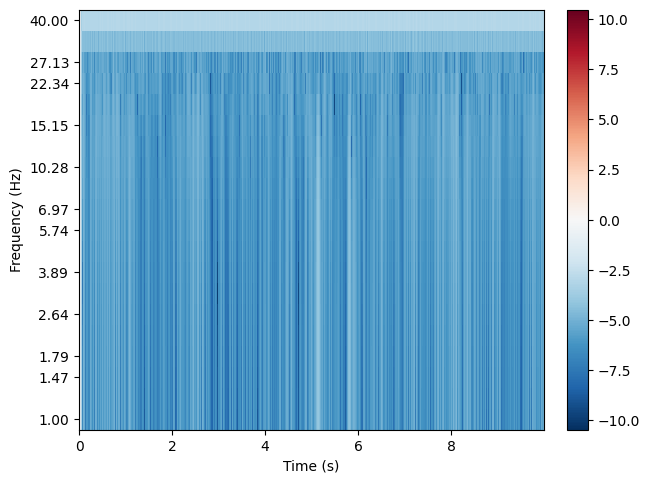

Channel 1 Spectrogram for Subject 5 Listening to Song 11


In [34]:
very_raw_power.plot(picks=first_channel_idx, baseline=(-0.5, 0), mode='logratio', show=True, colorbar=True, tmin=0, tmax=10)
print(f'Channel {first_channel_idx+1} Spectrogram for Subject {rand_subj} Listening to Song {rand_song}')